# UMAP on tuning indices features

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [2]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

In [3]:
def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

## Load and preprocess data

In [5]:
tc_datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'
datadir = data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

phase='wake'
bin_size=160
single_spikes=False

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))

labels_brain_regions = np.empty(0)

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        dataset = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size, single_spikes, path=data_dir)
        neuron_regions = dataset['metainfo']['neuron_regions']
        labels_brain_regions = np.concatenate((labels_brain_regions, neuron_regions))
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)

print(features_rates.shape)

labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)
print(filter_hdc.shape)

units:  85  hdc units:  22
units:  21  hdc units:  2
units:  46  hdc units:  7
units:  50  hdc units:  7
units:  55  hdc units:  5
units:  59  hdc units:  7
units:  11  hdc units:  2
units:  13  hdc units:  4
units:  17  hdc units:  4
units:  22  hdc units:  6
units:  28  hdc units:  5
units:  40  hdc units:  11
units:  43  hdc units:  11
units:  36  hdc units:  10
units:  32  hdc units:  5
units:  33  hdc units:  11
units:  56  hdc units:  14
(647, 6)
(647,)


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


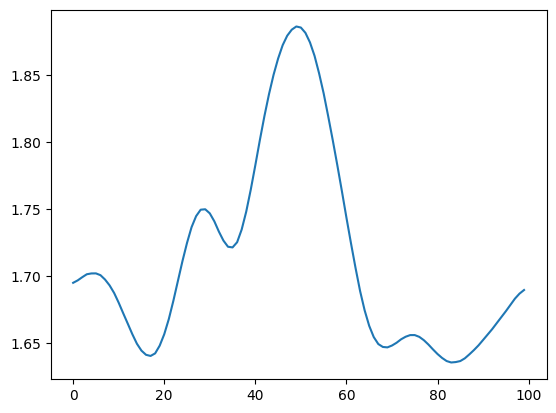

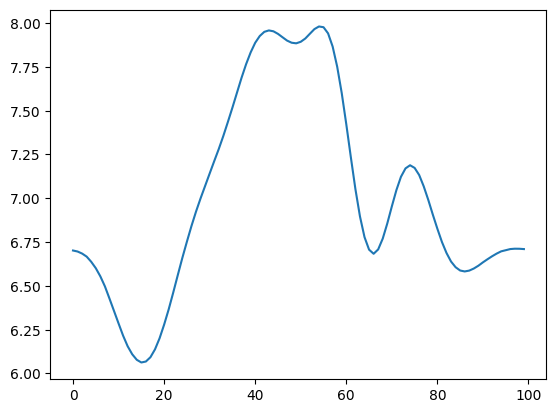

In [6]:
mouse_id = 'Mouse12'
session_id=120806
subset='nonhdc'
tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)

print(np.where(tc_rates < 0))

ne=6
plt.plot(tc_FF[ne,0,:])
plt.show()
plt.plot(tc_rates[ne,0,:])

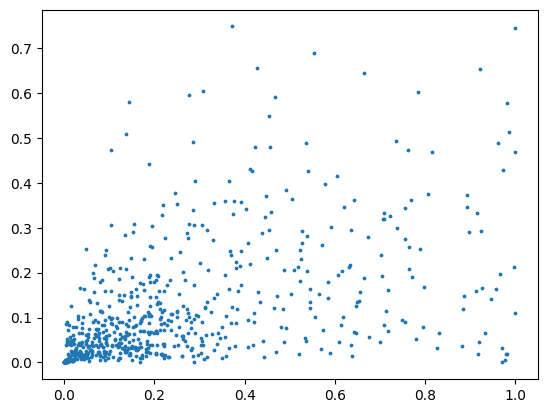

In [7]:
%matplotlib inline

plt.scatter(features_rates[:,5], features_FF[:,5], s=3)

In [8]:
def plot_umap_diff_mice(components, mice_sessions, num_hdc, num_nonhdc, plot_3d=False, title=None):
    num_neurons_per_mice = []
    for mouse_id in mice_sessions.keys():
        num = 0
        for session_id in mice_sessions[mouse_id]:
            num += num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id]
        num_neurons_per_mice.append(num)

    cum_neurons = np.cumsum(np.array(num_neurons_per_mice))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    colors = list(matplotlib.colors.BASE_COLORS)

    fig, ax = plt.subplots()
    for i, mouse_id in enumerate(mice_sessions.keys()):
            ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=mouse_id, alpha=0.4)
    if title is None:
        ax.set_title('UMAP projection')
    else:
        ax.set_title(title)
    ax.legend()
    ax.grid()
    
    if plot_3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for i, mouse_id in enumerate(mice_sessions.keys()):
                ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=mouse_id, alpha=0.4)
        if title is None:
            ax.set_title('UMAP projection')
        else:
            ax.set_title(title)        
        ax.legend()

In [9]:
def plot_umap_hdc_nonhdc(components, filter_hdc, plot_3d=False, title=None):
    fig, ax = plt.subplots()
    ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], alpha=0.4, c='r', label='hd neurons')
    ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], alpha=0.4, c='b', label='non-hd neurons')
    if title is None:
        ax.set_title('UMAP projection')
    else:
        ax.set_title(title)   
    ax.legend()
    ax.grid()
    
    if plot_3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], components[filter_hdc, 2], 
                   alpha=0.4, c='r', label='hd neurons')
        ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], components[np.invert(filter_hdc), 2], 
                   alpha=0.4, c='b', label='non-hd neurons')
        if title is None:
            ax.set_title('UMAP projection')
        else:
            ax.set_title(title)
        ax.legend()

In [10]:
def plot_umap_brain_regions(components, labels, plot_3d=False, title=None):
    
    region_names = ['ANT', 'PoS', 'CA1', 'mPFC']
    
    sorted_indices = np.argsort(labels)
    sorted_components = components[sorted_indices]

    num_neurons_per_region = []
    for i, region in enumerate(region_names):
        num_neurons_per_region.append(np.where(labels==i)[0].size)
    print(num_neurons_per_region)
    cum_neurons = np.cumsum(np.array(num_neurons_per_region))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    colors = list(matplotlib.colors.BASE_COLORS)

    fig, ax = plt.subplots()
    for i, region in enumerate(region_names):
        ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=region, alpha=0.4)
    if title is None:
        ax.set_title('UMAP projection')
    else:
        ax.set_title(title)
    ax.legend()
    ax.grid()
    
    if plot_3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for i, region in enumerate(region_names):
            ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], sorted_components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=region, alpha=0.4)
        if title is None:
            ax.set_title('UMAP projection')
        else:
            ax.set_title(title)        
        ax.legend()

In [11]:
import pandas as pd

mice_names = {}

label_neurons_per_mouse = []
for i, key in enumerate(mice_sessions.keys()):
    label_neurons_per_mouse.append(i)
    mice_names[i] = key


num_neurons_per_mice = []
i=0
for mouse_id in mice_sessions.keys():
    num = 0
    for session_id in mice_sessions[mouse_id]:
        num += num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id]
    num_neurons_per_mice.append(num)
label_neurons_per_mouse = np.repeat(label_neurons_per_mouse, num_neurons_per_mice)

mouse_ids = []
for i in range(len(label_neurons_per_mouse)):
    index = label_neurons_per_mouse[i]
    mouse_ids.append(mice_names[index])

hover_data = pd.DataFrame({'neuron': np.arange(features_rates.shape[0]),
                           'mouse_id': label_neurons_per_mouse
})

## UMAP on rate tuning indices

(647, 2)
[400, 176, 48, 23]


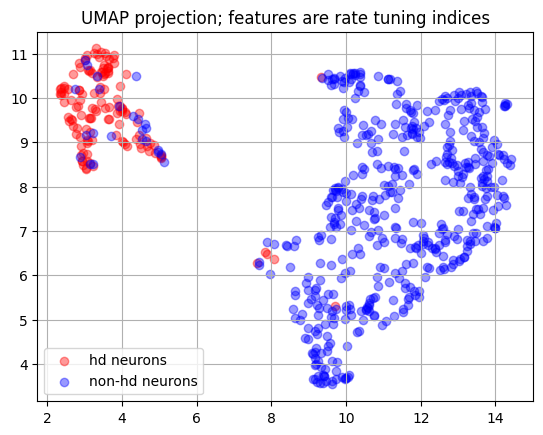

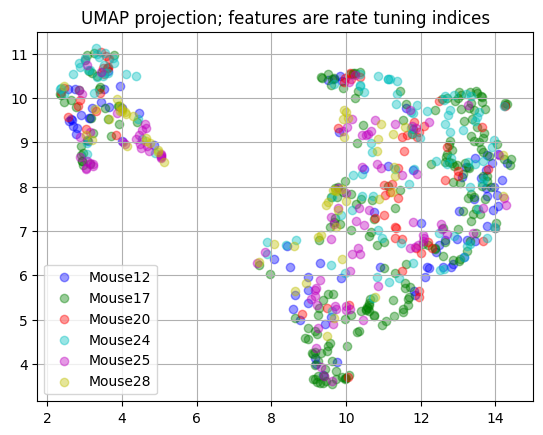

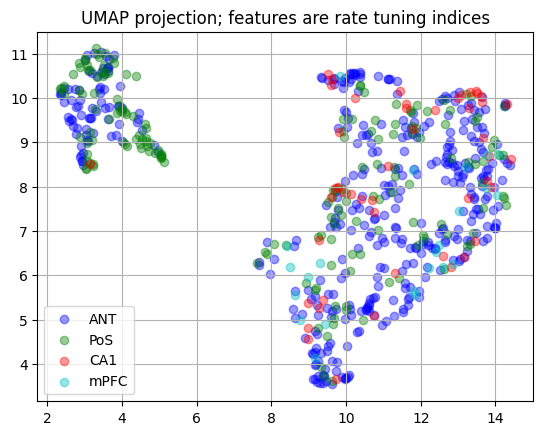

In [12]:
import umap

reducer = umap.UMAP(n_neighbors=20)
embedding_rates = reducer.fit_transform(features_rates)
print(embedding_rates.shape)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, title='UMAP projection; features are rate tuning indices')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, title='UMAP projection; features are rate tuning indices')
plot_umap_brain_regions(embedding_rates, labels_brain_regions, title='UMAP projection; features are rate tuning indices')

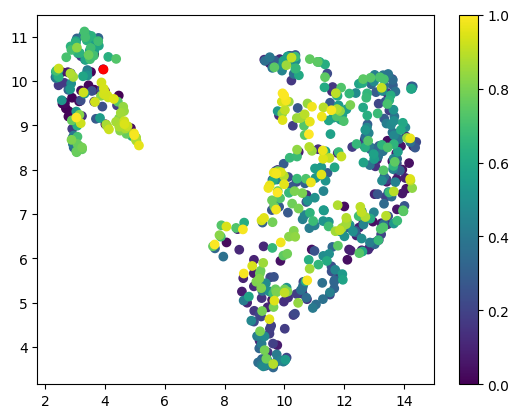

In [13]:
%matplotlib inline


plt.scatter(embedding_rates[:,0], embedding_rates[:, 1], c = np.arange(embedding_rates.shape[0]), cmap = 'viridis')
ne=10
plt.scatter(embedding_rates[ne,0], embedding_rates[ne, 1], color='red')
plt.colorbar();
plt.show()

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
[[ 1.         -0.55345215]
 [-0.55345215  1.        ]]


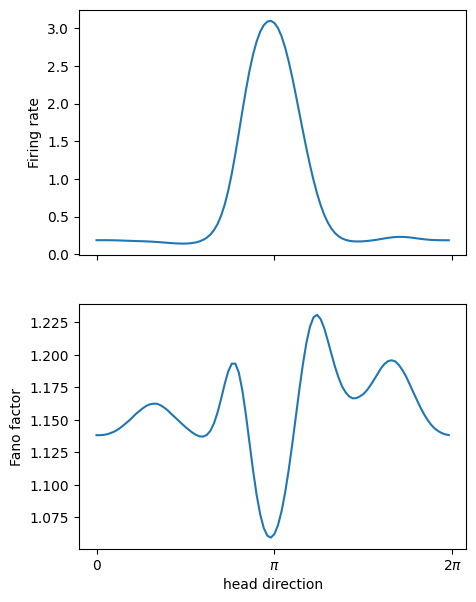

In [14]:
mouse_id = 'Mouse12'
session_id=120806
subset='hdc'
tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)

print(np.where(tc_rates < 0))

ne=10
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5,7))
ax[0].plot(tc_rates[ne,0,:])
ax[0].set_ylabel('Firing rate')
ax[1].plot(tc_FF[ne,0,:])
ax[1].set_xlabel('head direction')
ax[1].set_ylabel('Fano factor')
ax[1].set_xticks([0, 50, 100], ['0', '$\pi$', '$2\pi$'])

print(np.corrcoef(tc_rates[ne,0,:], tc_FF[ne,0,:]))

In [15]:
import umap.plot
mapper = umap.UMAP(n_neighbors=20).fit(features_rates)
umap.plot.output_notebook()

p = umap.plot.interactive(mapper, hover_data=hover_data, point_size=5)
umap.plot.show(p)

Loading BokehJS ...

## UMAP on fano factor tuning indices

(647, 2)
[400, 176, 48, 23]


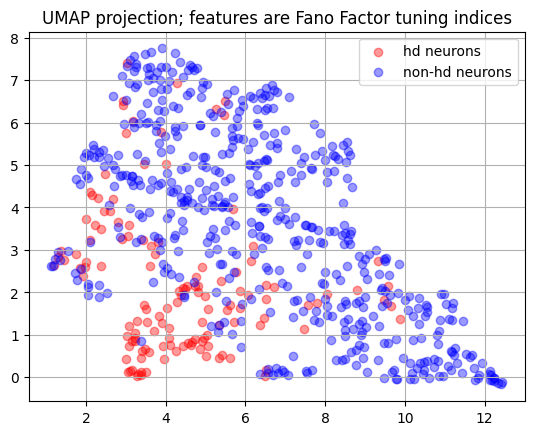

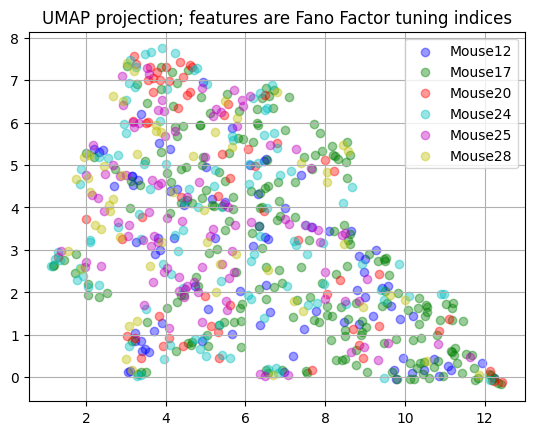

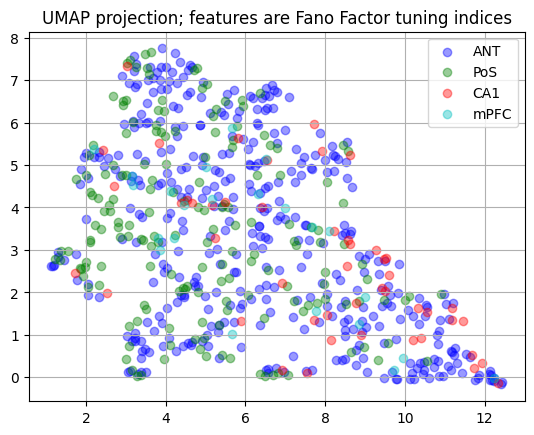

In [16]:
reducer2 = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding_ff = reducer2.fit_transform(features_FF)
print(embedding_ff.shape)
plot_umap_hdc_nonhdc(embedding_ff, filter_hdc, title='UMAP projection; features are Fano Factor tuning indices')
plot_umap_diff_mice(embedding_ff, mice_sessions, num_hdc, num_nonhdc, title='UMAP projection; features are Fano Factor tuning indices')
plot_umap_brain_regions(embedding_ff, labels_brain_regions, title='UMAP projection; features are Fano Factor tuning indices')

## 3D UMAP on fano factor features

(647, 3)
[400, 176, 48, 23]


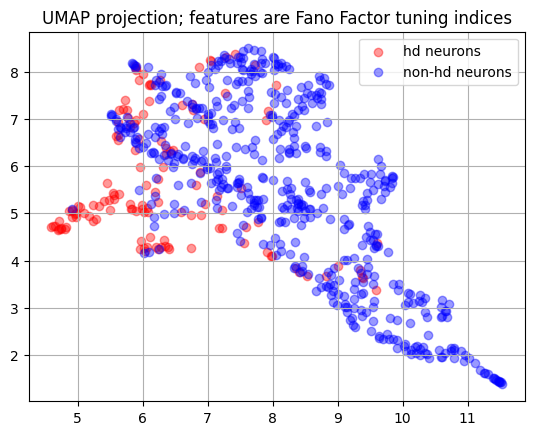

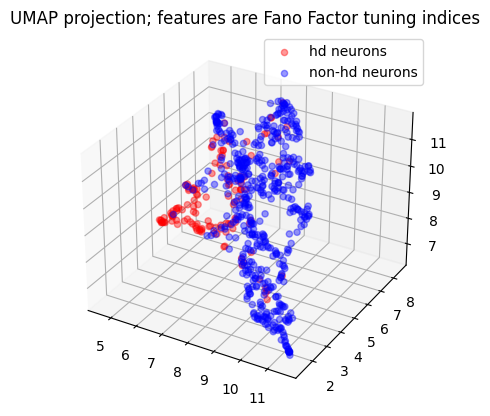

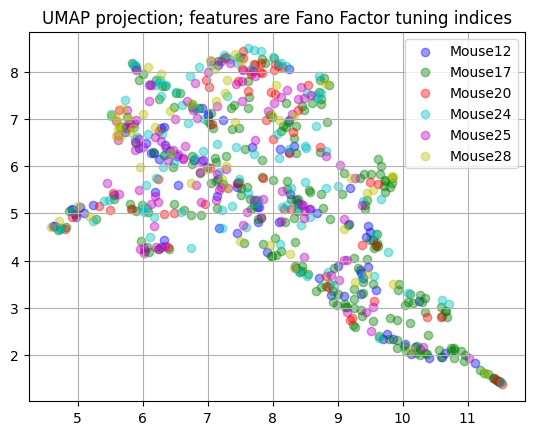

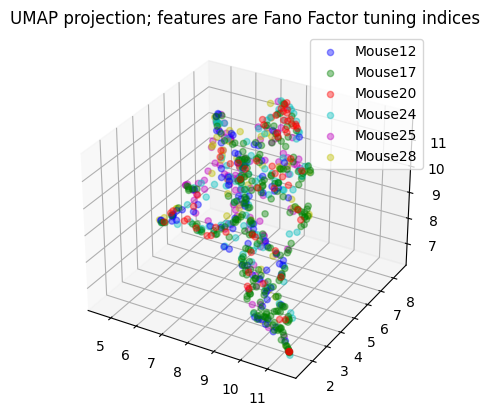

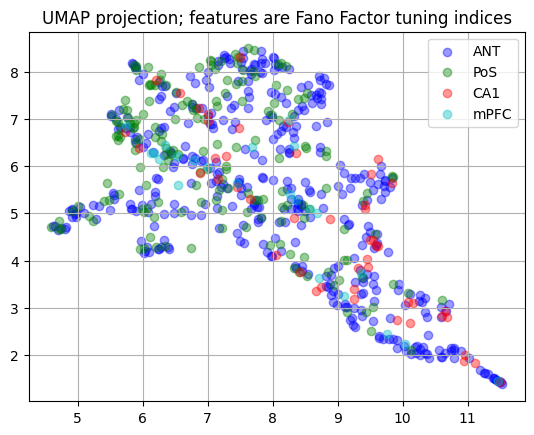

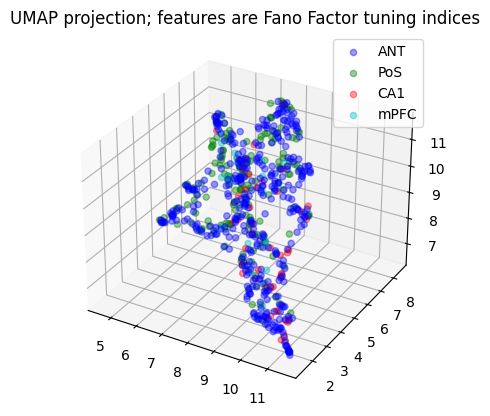

In [17]:
reducer3 = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
embedding_ff = reducer3.fit_transform(features_FF)
print(embedding_ff.shape)
plot_umap_hdc_nonhdc(embedding_ff, filter_hdc, plot_3d=True, title='UMAP projection; features are Fano Factor tuning indices')
plot_umap_diff_mice(embedding_ff, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are Fano Factor tuning indices')
plot_umap_brain_regions(embedding_ff, labels_brain_regions, plot_3d=True, title='UMAP projection; features are Fano Factor tuning indices')

## UMAP on the entire tuning curve

In [18]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = '120806'
subset='hdc'
data, _, _ = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
steps = data.shape[2]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, steps))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, steps))

correlation = []

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
            
            for i in range(tc_rates.shape[0]):
                correlation.append(np.corrcoef(tc_rates[i,0,:], tc_FF[i,0,:])[0,1])
            
            # first covariate is head direction, take the entire tuning curve on head direction
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = tc_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = tc_rates.shape[0]
            
            features_rates = np.concatenate((features_rates, tc_rates[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
            features_FF = np.concatenate((features_FF, tc_FF[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
print(features_rates.shape)
print(num_hdc)
labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)

print(filter_hdc.shape)

(647, 100)
{'Mouse12': {'120806': 22}, 'Mouse17': {'130125': 2, '130128': 7, '130131': 7, '130202': 5, '130203': 7}, 'Mouse20': {'130514': 2, '130515': 4, '130516': 4, '130517': 6}, 'Mouse24': {'131213': 5, '131217': 11, '131218': 11}, 'Mouse25': {'140124': 10, '140128': 5, '140129': 11}, 'Mouse28': {'140310': 14}}
(647,)


[400, 176, 48, 23]


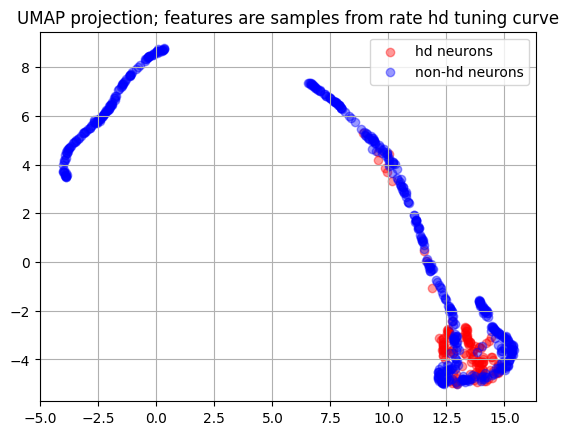

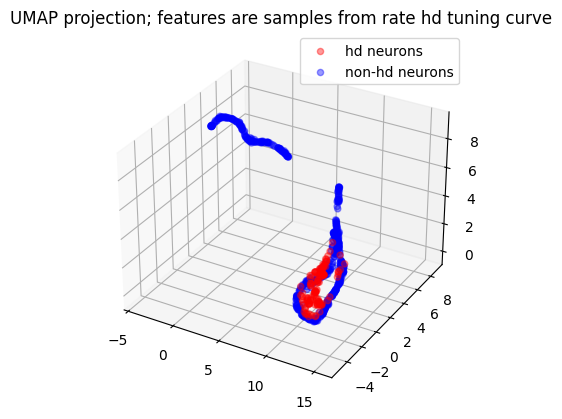

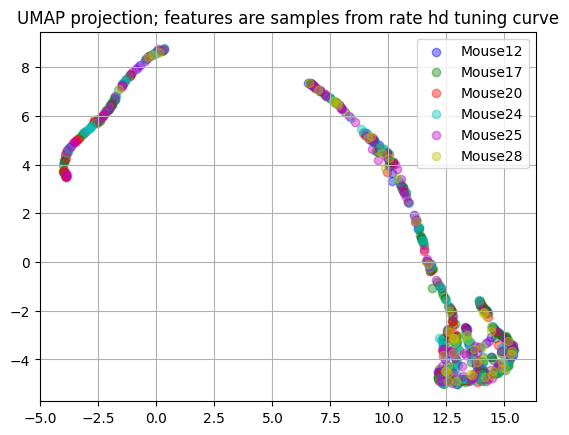

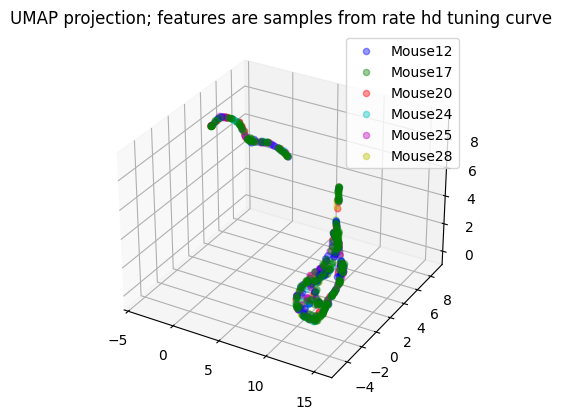

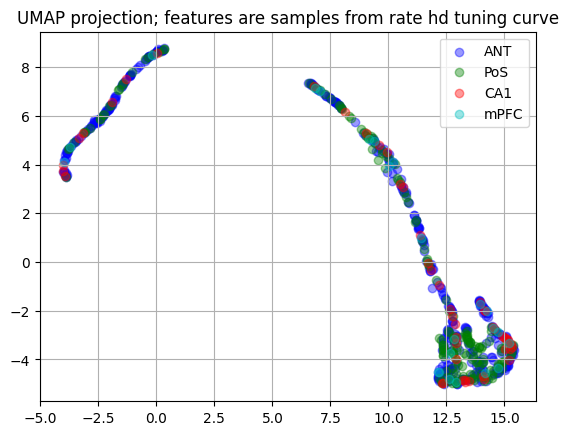

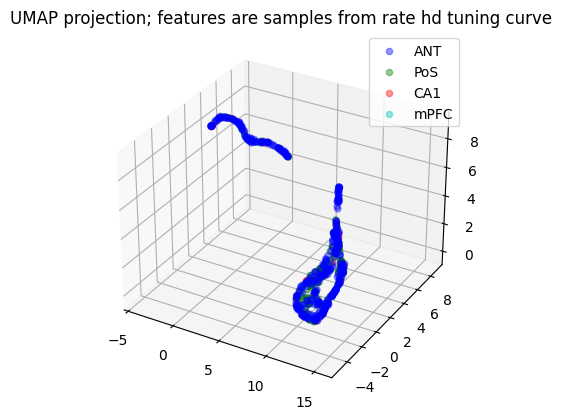

In [19]:
reducer = umap.UMAP(n_neighbors=25, min_dist=0.15 , n_components=3)
embedding_rates = reducer.fit_transform(features_rates)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')
plot_umap_brain_regions(embedding_rates, labels_brain_regions, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')

[400, 176, 48, 23]


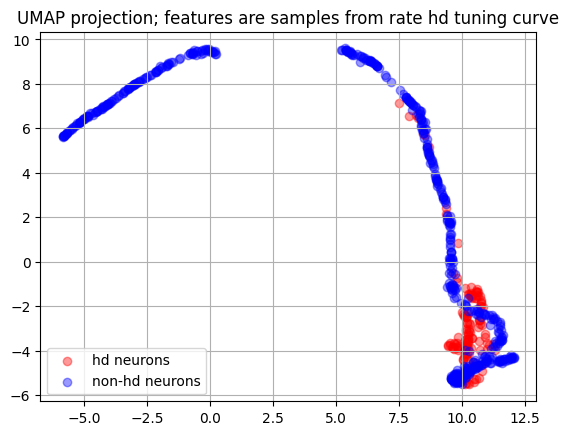

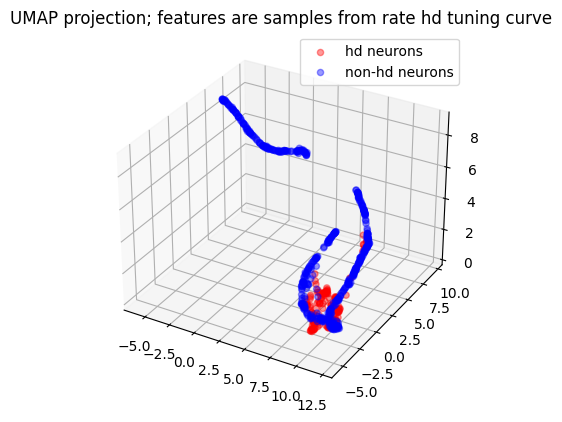

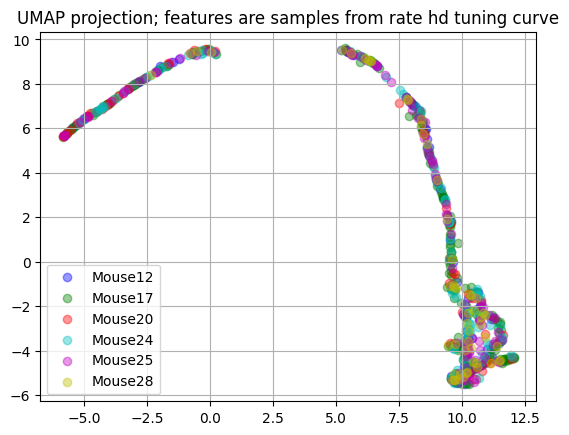

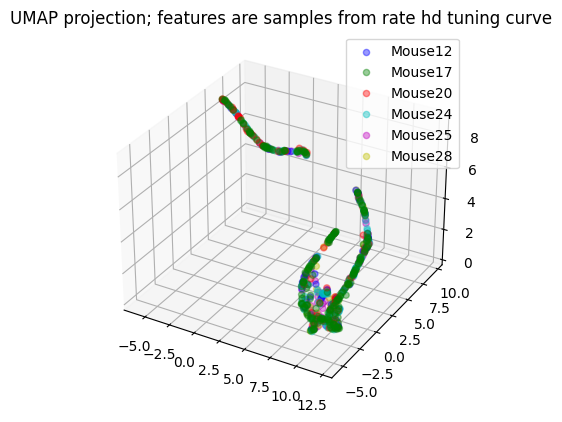

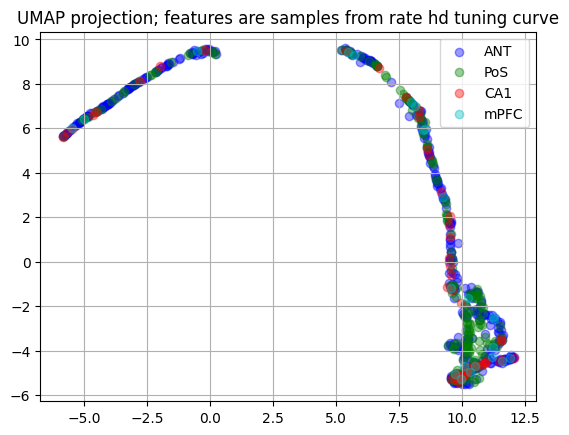

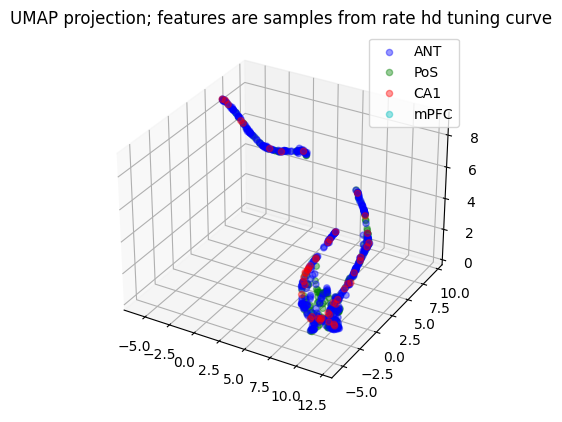

In [20]:
reducer = umap.UMAP(n_neighbors=25, min_dist=0.15 , n_components=3)
embedding_rates = reducer.fit_transform(features_rates)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')
plot_umap_brain_regions(embedding_rates, labels_brain_regions, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')

0.9993636399058294
-0.9999997585045907


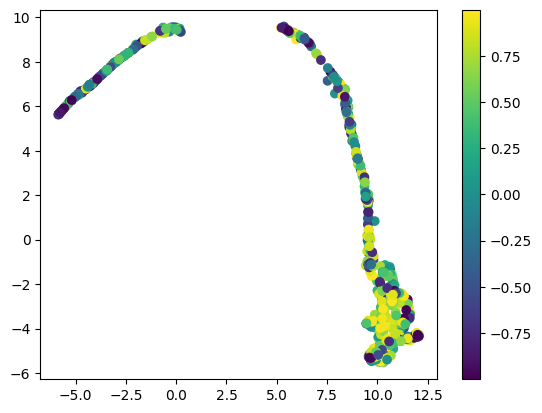

In [21]:
%matplotlib inline
print(np.max(correlation))
print(np.min(correlation))
plt.scatter(embedding_rates[:,0], embedding_rates[:, 1], c = correlation, cmap = 'viridis')
ne=10
plt.colorbar();
plt.show()

In [22]:
import umap.plot
mapper = umap.UMAP(n_neighbors=25, min_dist=0.15).fit(features_rates)
umap.plot.output_notebook()

p = umap.plot.interactive(mapper, hover_data=hover_data, point_size=5)
umap.plot.show(p)

Loading BokehJS ...

In [23]:
def find_neuron(mice_index, neuron):
    mice = list(mice_sessions.keys())
    num = 0
    for i in range(mice_index):
        neuron -= num_neurons_per_mice[i]
    
    for i, session in enumerate(mice_sessions[mice[mice_index]]):
        if num_hdc[mice[mice_index]][session] > neuron:
            return mice[mice_index], session, 'hdc', neuron
        neuron -= num_hdc[mice[mice_index]][session]
        if num_nonhdc[mice[mice_index]][session] > neuron:
            return mice[mice_index], session, 'nonhdc', neuron
        neuron -= num_nonhdc[mice[mice_index]][session]


In [24]:
num_neurons_per_mice

[85, 231, 63, 111, 101, 56]

Mouse17 130125 nonhdc 14
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


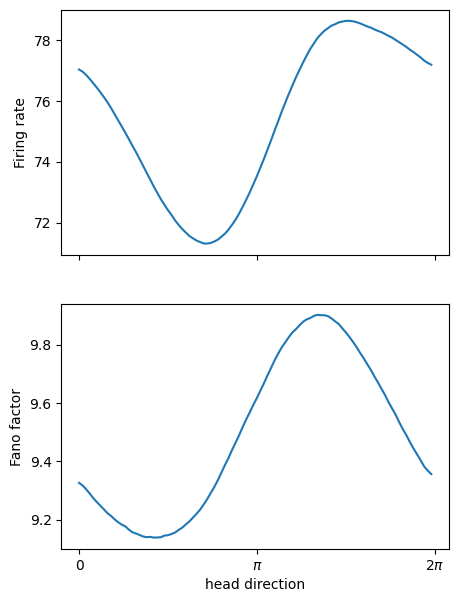

In [25]:
mouse_id, session_id, subset, neuron = find_neuron(1, 101)
print(mouse_id, session_id, subset, neuron)        

tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)

print(np.where(tc_rates < 0))

ne=10
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5,7))
ax[0].plot(tc_rates[ne,0,:])
ax[0].set_ylabel('Firing rate')
ax[1].plot(tc_FF[ne,0,:])
ax[1].set_xlabel('head direction')
ax[1].set_ylabel('Fano factor')
ax[1].set_xticks([0, 50, 100], ['0', '$\pi$', '$2\pi$'])

## UMAP for fano factor features

[400, 176, 48, 23]


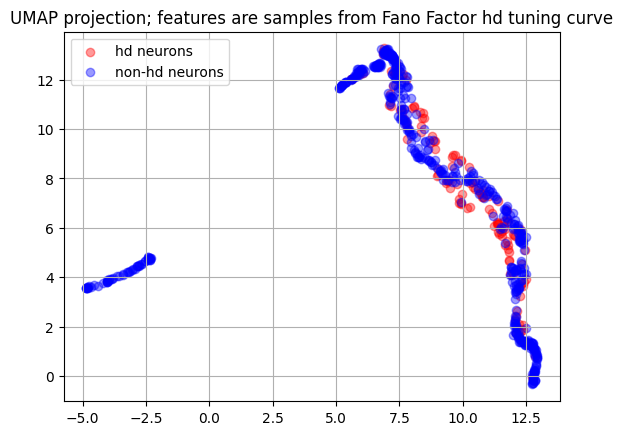

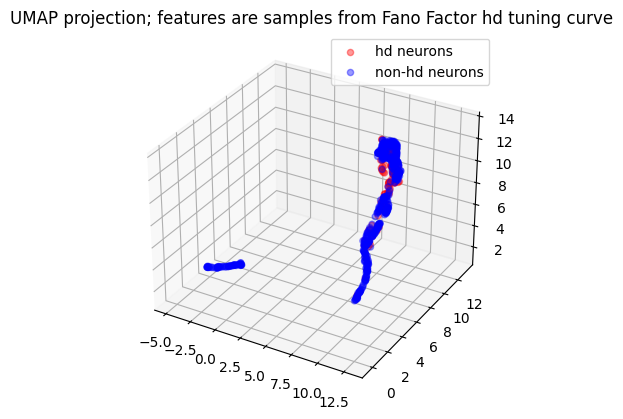

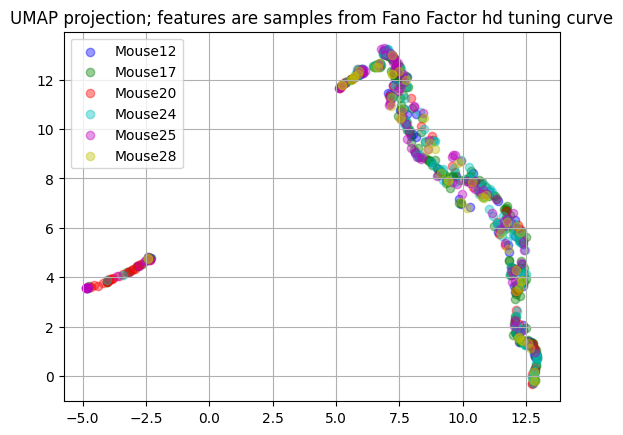

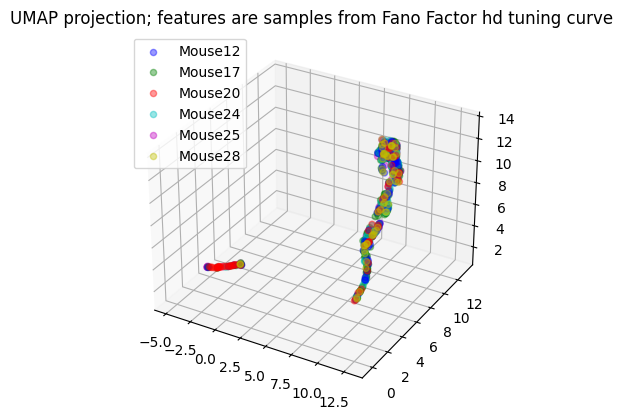

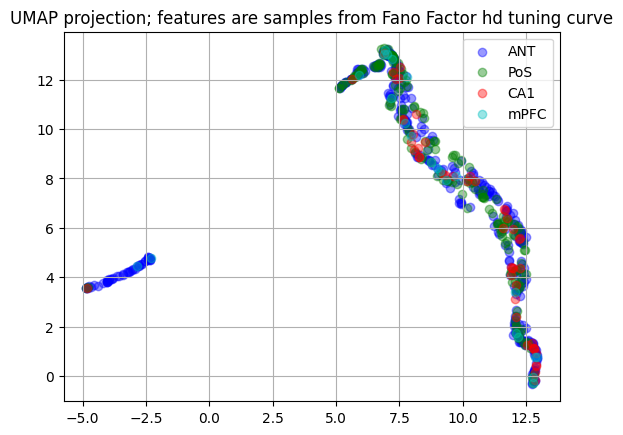

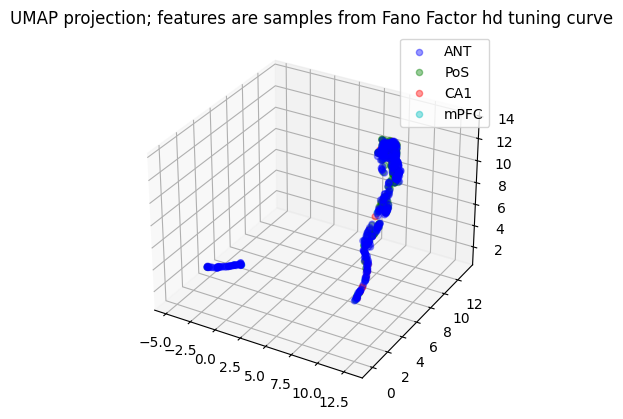

In [26]:
%matplotlib inline

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1 , n_components=3)
embedding_FF = reducer.fit_transform(features_FF)
plot_umap_hdc_nonhdc(embedding_FF, filter_hdc, plot_3d=True, title='UMAP projection; features are samples from Fano Factor hd tuning curve')
plot_umap_diff_mice(embedding_FF, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are samples from Fano Factor hd tuning curve')
plot_umap_brain_regions(embedding_FF, labels_brain_regions, plot_3d=True, title='UMAP projection; features are samples from Fano Factor hd tuning curve')

0.9993636399058294
-0.9999997585045907


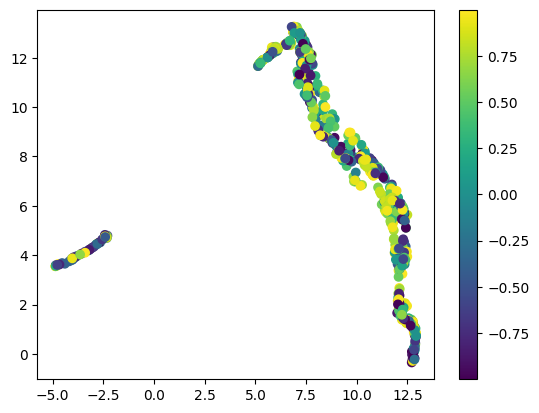

In [27]:
%matplotlib inline
print(np.max(correlation))
print(np.min(correlation))

plt.scatter(embedding_FF[:,0], embedding_FF[:, 1], c = correlation, cmap = 'viridis')
plt.colorbar();
plt.show()


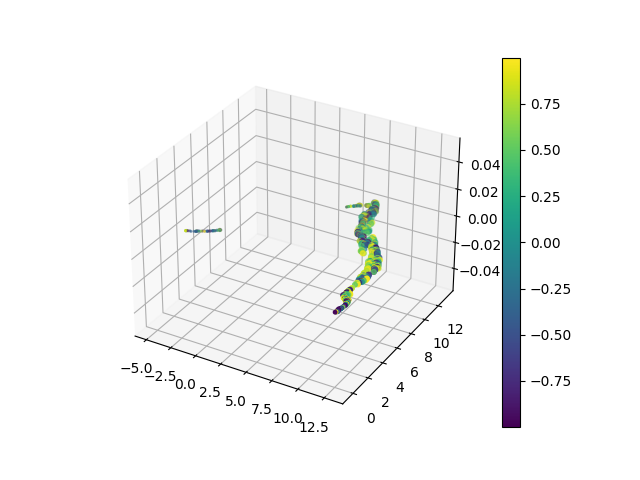

In [28]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.scatter(embedding_FF[:,0], embedding_FF[:, 1], embedding_FF[:, 2], c = correlation, cmap = 'viridis')
plt.colorbar();
plt.show()

## UMAP with correlation metric

[400, 176, 48, 23]


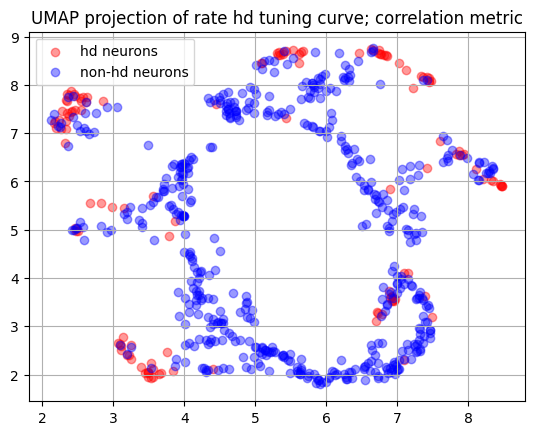

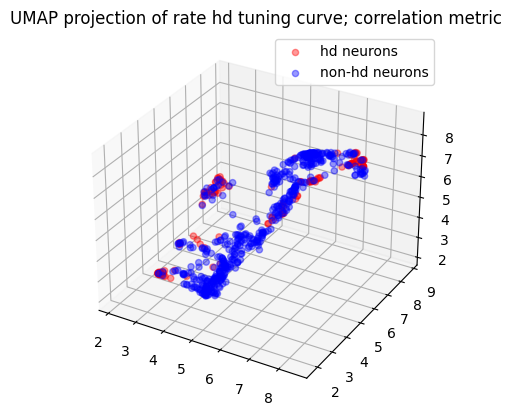

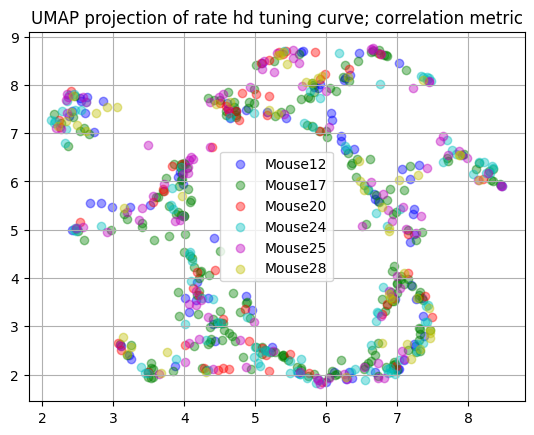

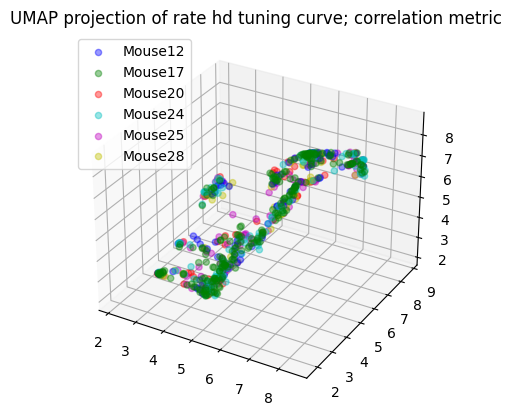

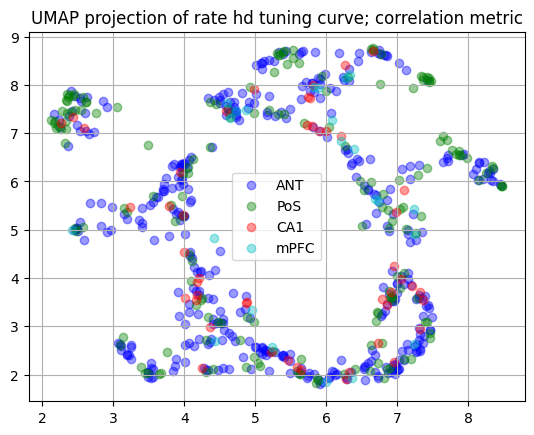

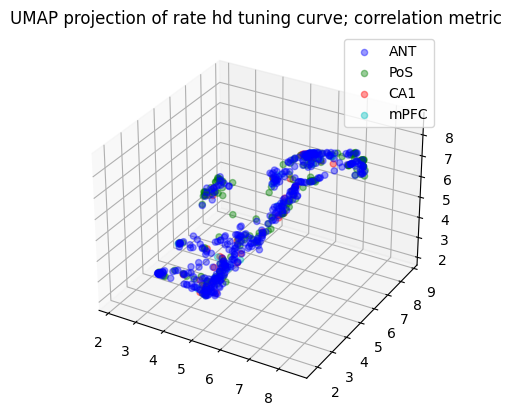

No such comm: 2d6b5cef30f5424c85ed23fe1cbd2b78
No such comm: 2d6b5cef30f5424c85ed23fe1cbd2b78
No such comm: 2d6b5cef30f5424c85ed23fe1cbd2b78
No such comm: 2d6b5cef30f5424c85ed23fe1cbd2b78
No such comm: 2d6b5cef30f5424c85ed23fe1cbd2b78
No such comm: 2d6b5cef30f5424c85ed23fe1cbd2b78


In [29]:
%matplotlib inline

reducer = umap.UMAP(n_neighbors=20, min_dist=0.05 , n_components=3, metric='correlation')
embedding_rates = reducer.fit_transform(features_rates)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')
plot_umap_brain_regions(embedding_rates, labels_brain_regions, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')

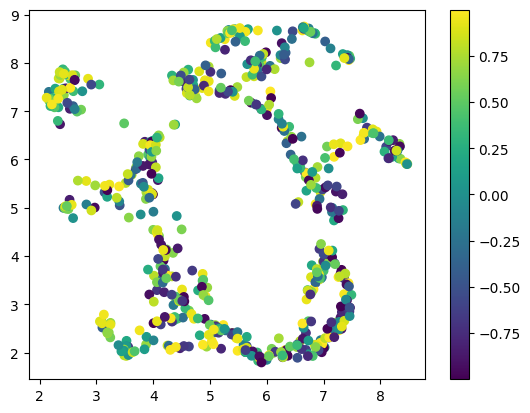

In [30]:
%matplotlib inline

plt.scatter(embedding_rates[:,0], embedding_rates[:, 1], c = correlation, cmap = 'viridis')
plt.colorbar();
plt.show()

In [ ]:
%matplotlib widget
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')

<AxesSubplot: >

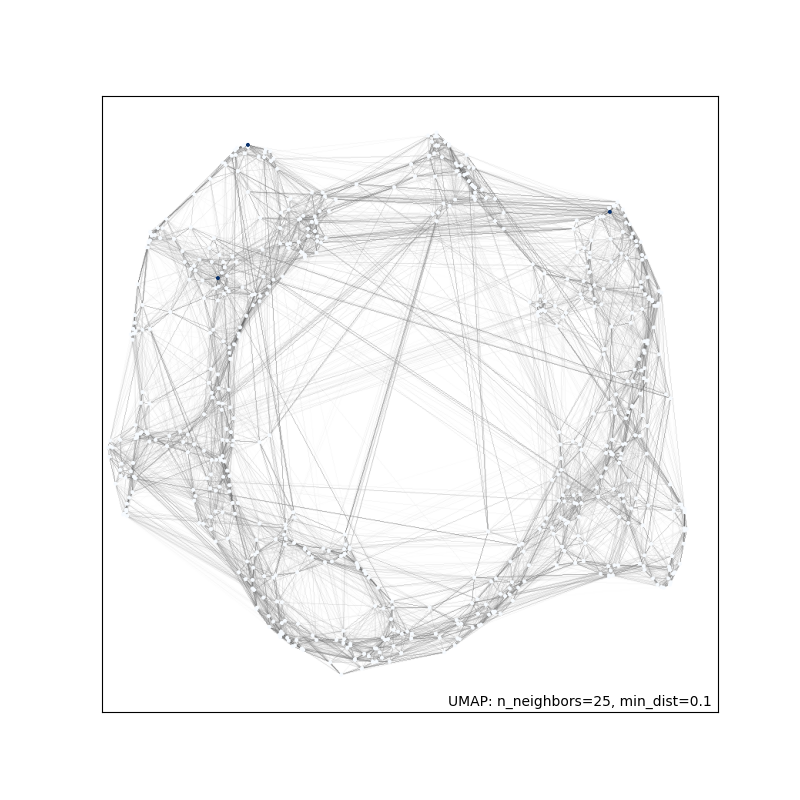

In [32]:
import umap.plot

reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='correlation').fit(features_rates)

umap.plot.connectivity(reducer, show_points=True)

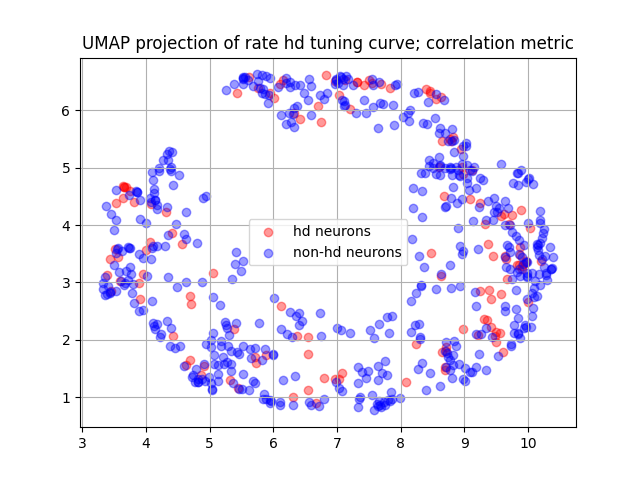

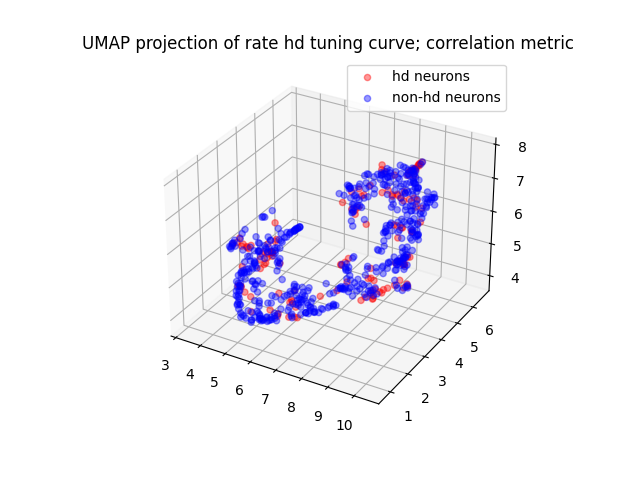

In [33]:
%matplotlib widget

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1 , n_components=3, metric='correlation')
embedding_ff = reducer.fit_transform(features_FF)
plot_umap_hdc_nonhdc(embedding_ff, filter_hdc, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')
#plot_umap_diff_mice(embedding_ff, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')
#plot_umap_brain_regions(embedding_ff, labels_brain_regions, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')

## Color according to max tuning angle

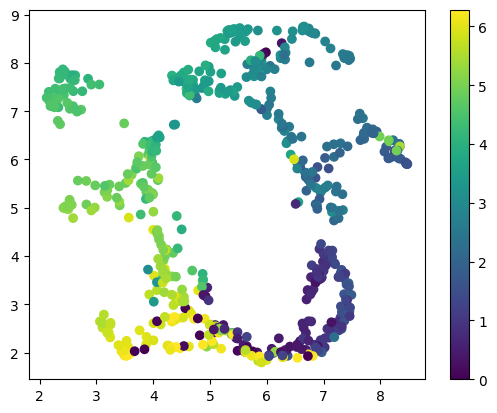

In [42]:
%matplotlib inline

max_index = np.argmax(features_rates, axis=1)
angles = np.linspace(0, 2*np.pi, features_rates.shape[1])
tuned_angle = [angles[i] for i in max_index]
plt.scatter(embedding_rates[:,0], embedding_rates[:, 1], c = tuned_angle, cmap = 'viridis')
plt.colorbar();
plt.show()

# UMAP on hd and non-hd neurons separate

In [34]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = '120806'
subset='hdc'
data, _, _ = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
steps = data.shape[2]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features_rates_hdc = np.empty((0, steps))
features_FF_hdc = np.empty((0, steps))
features_rates_nonhdc = np.empty((0, steps))
features_FF_nonhdc = np.empty((0, steps))

correlation = []

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
            
            for i in range(tc_rates.shape[0]):
                correlation.append(np.corrcoef(tc_rates[i,0,:], tc_FF[i,0,:])[0,1])
            
            # first covariate is head direction, take the entire tuning curve on head direction
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = tc_rates.shape[0]
                features_rates_hdc = np.concatenate((features_rates_hdc, tc_rates[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
                features_FF_hdc = np.concatenate((features_FF_hdc, tc_FF[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
            else:
                num_nonhdc[mouse_id][session_id] = tc_rates.shape[0]
                features_rates_nonhdc = np.concatenate((features_rates_nonhdc, tc_rates[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
                features_FF_nonhdc = np.concatenate((features_FF_nonhdc, tc_FF[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
print(features_rates_hdc.shape)
print(features_rates_nonhdc.shape)
print(num_hdc)
labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)

print(filter_hdc.shape)

(133, 100)
(514, 100)
{'Mouse12': {'120806': 22}, 'Mouse17': {'130125': 2, '130128': 7, '130131': 7, '130202': 5, '130203': 7}, 'Mouse20': {'130514': 2, '130515': 4, '130516': 4, '130517': 6}, 'Mouse24': {'131213': 5, '131217': 11, '131218': 11}, 'Mouse25': {'140124': 10, '140128': 5, '140129': 11}, 'Mouse28': {'140310': 14}}
(647,)


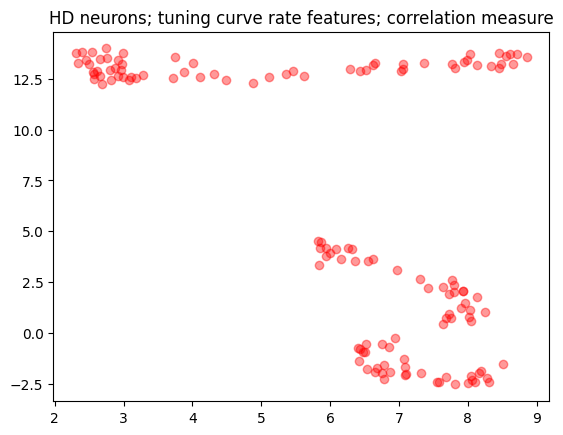

In [46]:
%matplotlib inline
import umap

reducer = umap.UMAP(n_neighbors=30, min_dist=0.3 , n_components=3, metric='correlation')
embedding_rates_hdc = reducer.fit_transform(features_rates_hdc)

fig, ax = plt.subplots()
ax.scatter(embedding_rates_hdc[:, 0], embedding_rates_hdc[:, 1], c='r', alpha=0.4)
plt.title('HD neurons; tuning curve rate features; correlation measure')
plt.show()

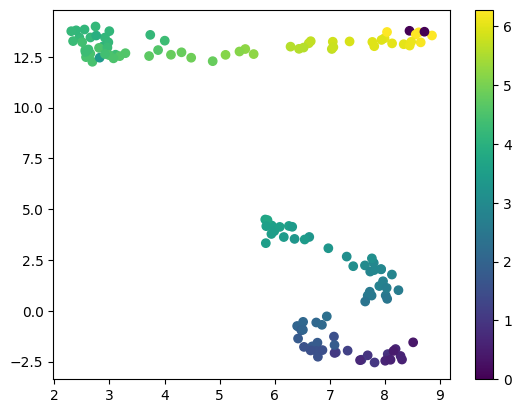

In [47]:
%matplotlib inline

max_index = np.argmax(features_rates_hdc, axis=1)
angles = np.linspace(0, 2*np.pi, features_rates_hdc.shape[1])
tuned_angle = [angles[i] for i in max_index]
plt.scatter(embedding_rates_hdc[:,0], embedding_rates_hdc[:, 1], c = tuned_angle, cmap = 'viridis')
plt.colorbar();
plt.show()

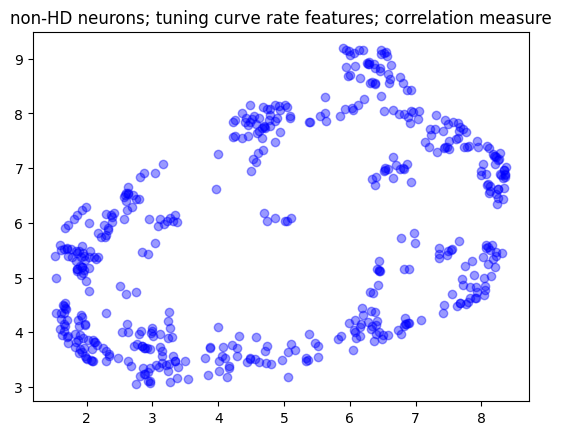

In [36]:
embedding_rates_nonhdc = reducer.fit_transform(features_rates_nonhdc)

fig, ax = plt.subplots()
ax.scatter(embedding_rates_nonhdc[:, 0], embedding_rates_nonhdc[:, 1], c='b', alpha=0.4)
plt.title('non-HD neurons; tuning curve rate features; correlation measure')
plt.show()

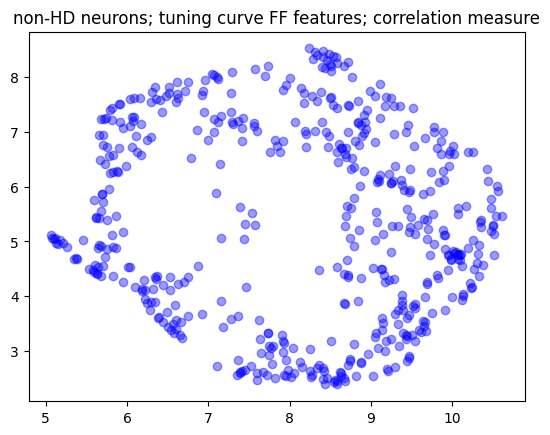

In [37]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1 , n_components=3, metric='correlation')
embedding_ff_nonhdc = reducer.fit_transform(features_FF_nonhdc)


fig, ax = plt.subplots()
ax.scatter(embedding_ff_nonhdc[:, 0], embedding_ff_nonhdc[:, 1], c='b', alpha=0.4)
plt.title('non-HD neurons; tuning curve FF features; correlation measure')
plt.show()

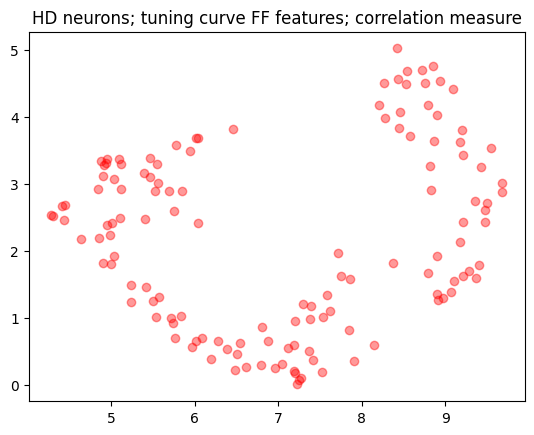

In [38]:
embedding_ff_hdc = reducer.fit_transform(features_FF_hdc)


fig, ax = plt.subplots()
ax.scatter(embedding_ff_hdc[:, 0], embedding_ff_hdc[:, 1], c='r', alpha=0.4)
plt.title('HD neurons; tuning curve FF features; correlation measure')
plt.show()